# <u>Walmart Product Review Analysis <u/>

### Goal
This analysis will look at Walmart clothing reviews to find key features that predict whether a customer will recommend an item or not. This investigation will be conducted using [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) packages and libraries. The features that guide the predictions can then used to guide Walmart's online and/or in-store marketing/product campaigns. 

### Notebook
Notebook ```1_walmart_product_review_nlp``` has cleaned the continuous variables. 
This notebook will be focused on the preprocessing steps for the text data which included, tokenization, removal of stopwords, lemmatization and Latend Dirichlet Allocation (LDA) model. 

In [1]:
# Data Cleaning and analysis packages
import pandas as pd
import numpy as np


# NLP packages
import re
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
from sklearn.preprocessing import OneHotEncoder


# Visualization packages
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings("ignore") 

import pickle

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 200)

In [2]:
#importing cleaned dataframe for preprocessing the texts. 
clean_df = pd.read_csv("../data/clean_df.csv", index_col = 0)

In [3]:
clean_df.head()

,item_name,price,overall_rating,num_rating,recommend,review_text,section,target,rating_bin
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['I bought this last year and am going to buy ...,men's clothing,0,1
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['I like wrangler, the pants is exactly for my...",men's clothing,1,1
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"[""If you like Big Men's style wearing jeans th...",men's clothing,1,1
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,['My husband loves these jeans and goes throug...,men's clothing,1,1
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Fit well Great price same jeans I was buying...,men's clothing,1,2


The raw review_text has a lot of noise. Will need to use regex to filter out all unnecesary characters. I will also remove numbers and apostrophes. 

In [4]:
# function will remove the unnecessary text and keep only english alphabet characters
# and return it in lower case
def clean_text(text):
    text.replace("\\n"," ")
    text =  ' '.join(re.sub("([^A-Za-z])"," ",text).split())
    return text.lower()

The clean_text function will be applied to both the review title and the review text and returned in new columns

In [5]:
# making a new column and applying the clean_text function on the review text
clean_df["clean_review_text"] = clean_df["review_text"].apply(clean_text)

In [6]:
# confirming new columns have been created. 
clean_df.head()

,item_name,price,overall_rating,num_rating,recommend,review_text,section,target,rating_bin,clean_review_text
0,Wrangler Men's Unlined Shirt Jacket,12.0,4.0,7.0,80.0,['I bought this last year and am going to buy ...,men's clothing,0,1,i bought this last year and am going to buy an...
1,Wrangler Men's Relaxed Fit Jeans,12.0,4.5,5840.0,90.0,"['I like wrangler, the pants is exactly for my...",men's clothing,1,1,i like wrangler the pants is exactly for my bo...
2,Wrangler Big Men's Relaxed Fit Jean,15.0,4.3,3257.0,88.0,"[""If you like Big Men's style wearing jeans th...",men's clothing,1,1,if you like big men s style wearing jeans thes...
3,Wrangler Men's 5 Star Regular Fit Jean with Flex,12.0,4.5,259.0,91.0,['My husband loves these jeans and goes throug...,men's clothing,1,1,my husband loves these jeans and goes through ...
4,Wrangler Men's and Big Men's 5 Star Relaxed Fi...,15.0,4.6,1490.0,91.0,['Fit well Great price same jeans I was buying...,men's clothing,1,2,fit well great price same jeans i was buying o...


# All text is now clean and ready to be used for feature engineering. 
Preprocessing steps:
- Tokenize and Lemmatize
- indentify stopwords
- Create a bag of words
- Textblob (subjectivity/polarity score)
- TfidfVectorizer # can be done right before train test split

In [7]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words=list(set(stopwords.words("english")))

In [8]:
# functions for preprocessing

# tokenize will tokenize all words
def tokenize(text):
    return nltk.word_tokenize(text)
# will remove all stop words
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]
# will lemmatize all words
def lemmatize_text(text):
     return [lemmatizer.lemmatize(word) for word in text]
# will create a FreqDist of the words.
# Will be used to track the change over the preprocessing steps. 
def fdist(df, column):
    corpus = " ".join([" ".join(text) for text in df[column].to_list()])
    corpus = tokenize(corpus)
    fdist=FreqDist(corpus)
    print(f"Number of words in corpus: {len(fdist)}")
    plt.figure(figsize=(10, 6))
    fdist.plot(20);

In [9]:
# creating a new column of tekenized words.
clean_df["tokenized"] = clean_df.clean_review_text.apply(tokenize)

Number of words in corpus: 10290


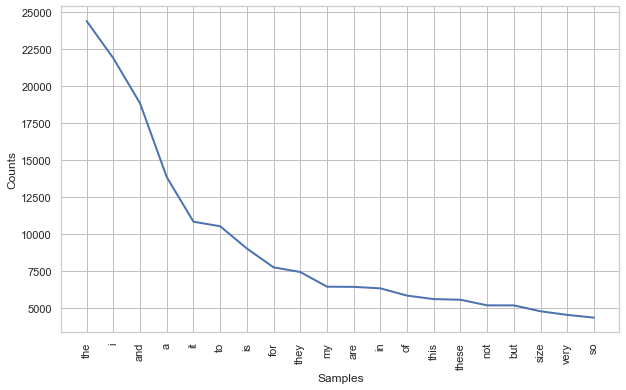

In [10]:
fdist(clean_df, "tokenized")

As expected, the majority of the words are stopwords, which provide little to no insight. 

In [11]:
# creating a new column with stopwords removed
clean_df["rem_stop"] = clean_df.tokenized.apply(remove_stopwords)

Number of words in corpus: 10143


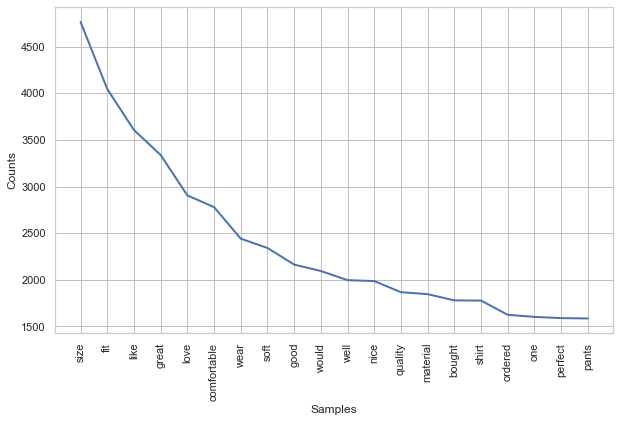

In [12]:
fdist(clean_df, "rem_stop")

After removing the stopwords (dropped 83 words), we see more descriptive words, which could be useful features in predicting the target. 

In [13]:
clean_df["lemma_words"] = clean_df.rem_stop.apply(lemmatize_text)

Number of words in corpus: 9083


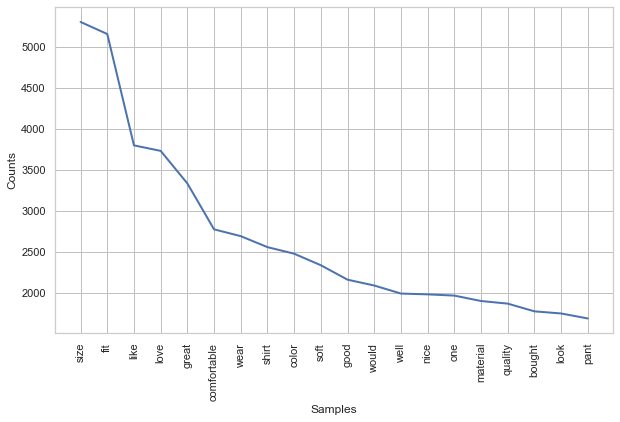

In [14]:
fdist(clean_df, "lemma_words")

Interestingly, size and fit seem to be very important and constantly refered to based on the FreqDist. Doing more EDA on this would be beneficial and I will use wordclouds to see the importance of words across recommended and non recommended items.

In [15]:
# creating seperate recommended and non recommended dataframes. 
no_rec = clean_df[clean_df.target == 0]
yes_rec = clean_df[clean_df.target == 1]

In [16]:
# only the lemmatized words will be used for the wordcloud. This way we can ingnore the stopwords. 
text = no_rec["lemma_words"].values
text = " ".join(" ".join(word) for word in text)

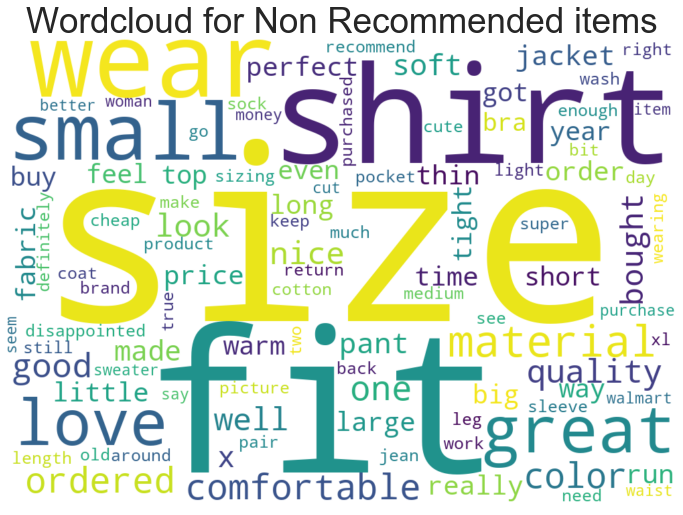

In [17]:
fig, ax = plt.subplots(figsize=(12,17))

wordcloud = WordCloud(max_words=100,collocations=False, width=1000, height=700, background_color="white", random_state=0).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for Non Recommended items", fontsize = 35)
plt.show()

In [18]:
# will do the same thing for recommended items
text = yes_rec["lemma_words"].values
text = " ".join(" ".join(word) for word in text)

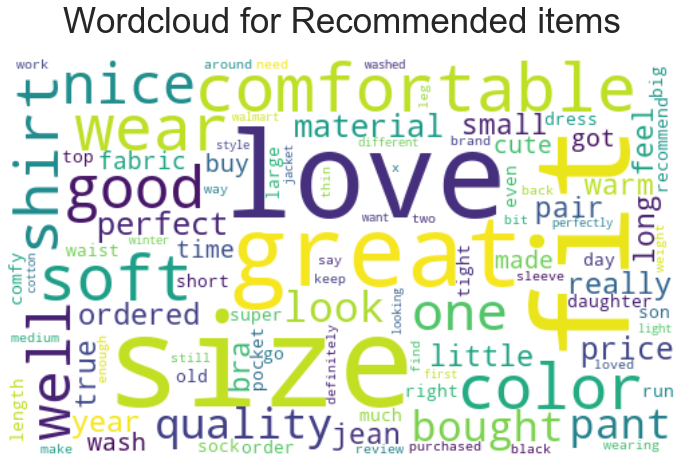

In [19]:
fig, ax = plt.subplots(figsize=(12,17))

wordcloud = WordCloud(max_words=100,collocations=False, width=500, height=300, background_color="white", random_state =0).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud for Recommended items", fontsize=35, pad=25)
plt.show()

Since size and fit are in both recommended and non recommended items, I will add this to the stopwords. However, it is important to note that these are the most frequest words in the corpus and need to be addressed in the findings. 

Adding new stopwords found from the word cloud. 

In [20]:
eda_stopwords = ["size", "color", "fit", "great", "pair", "right", "x", "xl", "nd", "de", "u", "la", "tbw", "c", "v", "great", "n", "wal", "wow","hi", "hello", "nmbc", "youll", "must", "said", "either", "lol", 'ill', "six", "goat", "thou", "un", "lb", "pair", "right", "x", "xl", "one", "way", "definitely", "shirt", "jacket", "daughter", "son" ]

stop_words=list(set(stopwords.words("english")))

stop_words.extend(eda_stopwords)

In [21]:
# removing the list around lemma_words for future feature engineering.
def list_to_str(text):
    return ", ".join(text)

clean_df["delisted"] = clean_df["lemma_words"].apply(list_to_str)

In [22]:
len(no_rec["clean_review_text"]), len(yes_rec["clean_review_text"])

(313, 836)

Since the section column is categorical, I will use OneHotEncoder to code it so it can be intrepreted by models. I do not believe these will be important features since we found them all to have roughly an even spread.

In [23]:
encoder = OneHotEncoder(handle_unknown="error", drop="first" )
coded_cat=pd.DataFrame(encoder.fit_transform(clean_df[["section"]]).toarray())

In [24]:
coded_cat.rename(columns={0:"girls'", 1:"men's", 2:"women's"},inplace=True)

In [25]:
# combining the new dataframe of coded section with the main dataframe. 
frames = [clean_df, coded_cat]
df = pd.concat(frames, axis=1)

In [26]:
df.shape

(1149, 17)

Before we dive into LDA modeling, I need to remove the added stopwords that were discovered from the wordcloud. 

In [27]:
clean_df["lemma_words"] = clean_df["lemma_words"].apply(remove_stopwords)

# LDA (Topic) Model

The reason for creating a topic model is to see if there are words that can be grouped together. I hypothesize that there will be no luck with finding good topic models but its worth the try. The algorithm might find something that I missed in my eda. 

In [28]:
# creating a dictionary from the delisted column. 
# There is no difference between the delisted and lemm_words column when it comes to the words itself. 
# So I will use the two interchangeably depending on which works. 
dataset = [d.split() for d in clean_df.delisted]
vocab = gensim.corpora.Dictionary(dataset)


In [29]:
dictionary = gensim.corpora.Dictionary(clean_df["lemma_words"])
dictionary.filter_extremes(no_above=0.5)

In [30]:
sparce_matrix = [dictionary.doc2bow(doc) for doc in clean_df["lemma_words"]]

In [31]:
tfidf = models.TfidfModel(sparce_matrix)
corpus_tfidf = tfidf[sparce_matrix]

In [32]:
%%time
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,  num_topics=10, id2word=vocab, passes=50, workers=8, random_state=0)

CPU times: user 1min 26s, sys: 3.3 s, total: 1min 29s
Wall time: 1min 36s


In [33]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \n\Word: {}\n'.format(idx, topic))

Topic: 0 
\Word: 0.004*"reasonably," + 0.002*"cutting," + 0.001*"string," + 0.001*"heavily," + 0.001*"switch," + 0.001*"overstuffed," + 0.001*"sleek," + 0.000*"amazing" + 0.000*"lady," + 0.000*"familiar,"

Topic: 1 
\Word: 0.002*"thy," + 0.001*"speaking," + 0.000*"desperate," + 0.000*"picked," + 0.000*"luandy," + 0.000*"cutting," + 0.000*"flowing," + 0.000*"extreme," + 0.000*"puffy," + 0.000*"izod,"

Topic: 2 
\Word: 0.002*"useful," + 0.001*"warm" + 0.001*"thumb," + 0.001*"til," + 0.000*"notification," + 0.000*"disappearing," + 0.000*"brand," + 0.000*"consumer," + 0.000*"absolute," + 0.000*"luandy,"

Topic: 3 
\Word: 0.004*"gilet," + 0.004*"pannier," + 0.003*"stay," + 0.003*"em," + 0.003*"bootcut," + 0.003*"significant," + 0.003*"incident," + 0.002*"watch," + 0.002*"brief," + 0.002*"flare,"

Topic: 4 
\Word: 0.002*"thou," + 0.001*"zuckerberg," + 0.000*"heated," + 0.000*"described," + 0.000*"energy," + 0.000*"dropped," + 0.000*"padding," + 0.000*"hoping," + 0.000*"wish," + 0.000*"cushio

In [34]:
corpus_transformed = lda_model_tfidf[sparce_matrix]

In [35]:
%%time
# convert to dataframe
topics = [dict(x) for x in corpus_transformed]

# convert list of lda topic weights to dataframe
lda_tfidf_df = pd.DataFrame(topics)
# rename columns
lda_tfidf_df.rename(columns={i: f'topic{i}' for i in range(10)}, inplace=True)

lda_tfidf_df.fillna(0, inplace=True)

CPU times: user 225 ms, sys: 7.28 ms, total: 232 ms
Wall time: 241 ms


In [36]:
#confirming the dataframe is valid.
lda_tfidf_df

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.011115,0.011115,0.011115,0.122070,0.011115,0.011115,0.789009,0.011115,0.011115,0.011115
1,0.000000,0.000000,0.000000,0.010731,0.000000,0.000000,0.987497,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.023174,0.000000,0.000000,0.974768,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.021575,0.000000,0.000000,0.974928,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.023940,0.000000,0.000000,0.973633,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1144,0.012501,0.012501,0.012501,0.012501,0.012501,0.012501,0.887487,0.012501,0.012501,0.012501
1145,0.000000,0.000000,0.000000,0.054816,0.000000,0.000000,0.905171,0.000000,0.000000,0.000000
1146,0.000000,0.000000,0.000000,0.022728,0.000000,0.000000,0.960598,0.000000,0.000000,0.000000
1147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.989532,0.000000,0.000000,0.000000


In [38]:
filename = "../pickle_jar/lda.pkl"
outfile = open(filename, "wb")

In [39]:
pickle.dump(lda_tfidf_df,outfile)
outfile.close

<function BufferedWriter.close>

Topic 6 seems to be dominating the dataframe. 
This may be because customers are describing how either their puchase was a "mistake" or how it was "worth" the price. However, the words are not unique enough for me to classifiy and give it a topic summary.  But since these topics do seem important, this is something I will need to take into consideration in the modeling notebook. Therefore, I need to join the LDA topic modeling dataframe with the main dataframe. 


In [40]:
frames = [df, lda_tfidf_df]
df = pd.concat(frames, axis=1)
#confirming the merge worked
df.shape

(1149, 27)

Converting the dataframe to ```.csv``` introduces unwanted noise and corrupts the dataframe. Dataframe will be pickled to be used in the next notebook for modeling. 

In [42]:
filename = "../data/modeling_df.pkl"
outfile = open(filename, "wb")

In [43]:
pickle.dump(df,outfile)
outfile.close

<function BufferedWriter.close>

In [46]:
#df[df["delisted"].str.contains("mistake")]

In [47]:
#df.iloc[387].review_text